<a href="https://colab.research.google.com/github/karolamistrz2000/expense_tracker/blob/main/phy122_lab5t.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Title of Work

Name

Date

#   <font color='Green'> **Setup** </font>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(precision=4, linewidth=200, threshold=2000, suppress=True)

π = np.pi

In [ ]:
import scipy
from scipy.special import ellipj, ellipk

def get_radian(deg):
    return π * deg / 180

def get_degree(rad):
    return 180 * rad / π

def get_ω(time):
    dtt = time[1] - time[0]
    return 2*π * np.linspace(0.0, 1.0/(2.0*dtt), int(len(time)/2))

def get_Qdot(Q, L, IIi):

    ω = np.append([0.],  IIi @ L)

    B = 0.5*np.asarray([[ Q[0], -Q[1], -Q[2], -Q[3] ],
                        [ Q[1],  Q[0], -Q[3],  Q[2] ],
                        [ Q[2],  Q[3],  Q[0], -Q[1] ],
                        [ Q[3], -Q[2],  Q[1],  Q[0] ]])

    return B @ ω

def get_EulerAngles(Q):

    φ = np.arctan2( 2*(Q[0]*Q[1] + Q[2]*Q[3]) , 1 - 2*(Q[1]**2 + Q[2]**2) )
    θ = np.arcsin(  2*(Q[0]*Q[2] + Q[3]*Q[1] ) ) ## np.tan() ?? np.arcsin
    ψ = np.arctan2( 2*(Q[0]*Q[3] + Q[1]*Q[2]) , 1 - 2*(Q[2]**2 + Q[3]**2) )

    return np.asarray([φ, θ, ψ])

def get_Qauternions(Θ):

    φ = Θ[0]
    θ = Θ[1]
    ψ = Θ[2]

    ## Q[0] has all cosines, then for each component replace one sine, then add/subtract the flip of this
    Q = np.asarray([ np.cos(φ/2)*np.cos(θ/2)*np.cos(ψ/2) + np.sin(φ/2)*np.sin(θ/2)*np.sin(ψ/2),
                     np.sin(φ/2)*np.cos(θ/2)*np.cos(ψ/2) - np.cos(φ/2)*np.sin(θ/2)*np.sin(ψ/2),
                     np.cos(φ/2)*np.sin(θ/2)*np.cos(ψ/2) + np.sin(φ/2)*np.cos(θ/2)*np.sin(ψ/2),
                     np.cos(φ/2)*np.cos(θ/2)*np.sin(ψ/2) - np.sin(φ/2)*np.sin(θ/2)*np.cos(ψ/2)])

    return Q

def sn(arg, k):
    sn = scipy.special.ellipj( arg , k)[0]
    return np.nan_to_num(sn, nan=1.)


def EllipticK(k):
    return scipy.special.ellipk(k)


class PhysicalPendulum(object):
    # 6/30/21
    ''' Pendulum Initialization '''
    def __init__(self):

        ### Constants
        self.g    = 9.81 # meters/second-squared : gravitational acceleration
        self.L    = 1.00 # meters : moment-of-inertia length
        #self.R    = 1.00 # meters : rotation-arm length
        self.drag = 0.00 # kg/seconds : Stokes drag / viscous damping coefficient
        self.mass = 1.00 # kg

        ### calculated constants
        self.I    = self.mass * (self.L)**2 # moment-of-inerta for point-mass around L
        self.II   = self.I * np.eye(3)
        self.IIi  = np.linalg.inv(self.II)
        self.C1   = self.IIi * self.drag
        self.C2   = self.IIi * self.L * self.mass * self.g
        self.ω0   = np.sqrt( self.C2[0][0] )

        ### calculations
        self.angle0      = None
        self.dynamicsrun = None
        self.dynamicst   = None
        self.freqprofile = None
        self.freq        = None

    def dynamics(self, Θ_0, dt=0.01, T=100, ω_0=[0.,0.,0.], error=0.25, dimension=1):

        ### calculated constants
        self.Θ    = Θ_0
        self.I    = self.mass * (self.L)**2 # moment-of-inerta for point-mass around L
        self.II   = self.I * np.eye(3)
        self.IIi  = np.linalg.inv(self.II)
        self.C1   = self.IIi * self.drag
        self.C2   = self.IIi * self.L * self.mass * self.g
        self.ω0   = np.sqrt( self.C2[0][0] )

        self.angle0 = Θ_0
        Θ_0    = np.asarray([Θ_0, 0.0, 0.0])
        Θ_0    = get_radian(Θ_0)
        L      = self.II @ ω_0
        time   = np.arange(0, T, dt)
        Q      = get_Qauternions(Θ_0)
        θ_data = np.zeros( (time.shape[0], 3) )

        for i in range(len(time)):

            θ_data[i] = get_degree( get_EulerAngles(Q) + (Θ_0[0]/180) * error*(np.random.rand(3) - 0.5) )

            τ = self.II @ ( - self.C2 @ np.sin(get_EulerAngles(Q)) - self.C1 @ ( self.IIi @ L ) ) ## leave τ & L in Euler angles!

            L_t = L + dt * τ / 2
            L   = L + dt * τ

            Qdot_t = get_Qdot(Q, L_t, self.IIi)
            Qdt = Q + dt/2 * Qdot_t

            Qdot_tdt = get_Qdot(Qdt, L, self.IIi)
            Q = Q + dt * Qdot_tdt

        self.dynamicst   = time
        self.dynamicsrun = (θ_data[:,:dimension].T)[0]

        return self.dynamicst , self.dynamicsrun

    def frequency(self):
        self.freq   = get_ω(self.dynamicst)
        self.freqprofile = np.abs(2.0/len(self.dynamicst) * (np.fft.fft( self.dynamicsrun, axis=0 ))[:len(self.dynamicst)//2])
        self.getmax = self.freq[np.argmax(self.freqprofile)]
        return self.freq / (2 * np.pi), self.freqprofile

    def exactdynamics(self):
        t = self.dynamicst

        k  = np.sin( get_radian(self.angle0)/2 )**2
        K  = scipy.special.ellipk(k)
        Θt  = self.angle0 * sn(self.ω0 * t + K , k)

        return Θt

#   <font color='Red'> **Getting Started** </font>

####   <font color='Red'> To get started, let's define a pendulum object </font>

In [ ]:
# Defining initial properties of the pendulum
class Pendulum:
    def __init__(self, mass, length, gravity=9.8):
        self.mass = mass
        self.length = length
        self.gravity = gravity

# Creating a pendulum instance
pendulum = Pendulum(mass=1.0, length=1.0)

####   <font color='Red'> Next, let's change the objects: mass, L (length), gravity. </font>

In [ ]:
# Adjusting pendulum properties
pendulum.mass = 1.0  # mass in kilograms
pendulum.length = 2.0  # length in meters
pendulum.gravity = 9.8  # acceleration due to gravity in m/s^2

####   <font color='Red'> Next, let's run the dynamics with an ideal release angle of your choice (in degrees). </font>

In [ ]:
# Simulating pendulum dynamics
def pendulum_dynamics(theta0_deg, length, gravity, time):
    theta0 = get_radian(theta0_deg)
    ω0 = 0.0  # initial angular velocity
    t = np.linspace(0, time, 1000)
    omega = np.sqrt(gravity / length)

    theta = theta0 * np.cos(omega * t)
    return t, get_degree(theta)

# Running the simulation
time = 10  # total simulation time in seconds
theta0_deg = 45  # release angle in degrees
t, theta = pendulum_dynamics(theta0_deg, pendulum.length, pendulum.gravity, time)

####   <font color='Red'> Next, let's plot our dynamics results. </font>

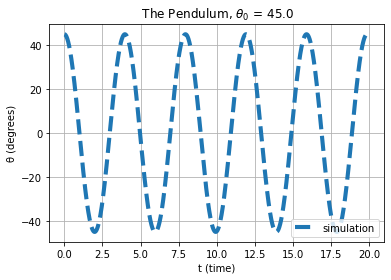

In [ ]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(t, theta, label='Simulation', linestyle='--', color='blue')
plt.title(r'The Pendulum, $\theta_0$ = {:.1f}°'.format(theta0_deg))
plt.xlabel('Time (s)')
plt.ylabel(r'$\theta$ (degrees)')
plt.legend()

This plot shows the angular displacement of a pendulum over time, with an initial release angle of 45 degrees.
The oscillatory motion indicates simple harmonic motion, where the pendulum periodically returns to its equilibrium position.
This is governed by the restoring force due to gravity and the length of the pendulum, which determines the period of oscillation.

###   <font color='Red'> Determine-and-Print the Period & the frequency of the plot above, using only the graph (and data above): </font>

In [ ]:
# Determine and Print the Period & Frequency using the graph and data
def calculate_period_and_frequency(t, theta):
    # Find the indices where the pendulum crosses the equilibrium (theta = 0)
    zero_crossings = np.where(np.diff(np.sign(theta)))[0]
    periods = np.diff(t[zero_crossings])  # Calculate the time difference between zero crossings

    # Calculate the average period (considering only valid cycles)
    period = np.mean(periods) * 2  # Multiplied by 2 for a full oscillation
    frequency = 1 / period  # Frequency is the inverse of the period

    return period, frequency

# Calculate the period and frequency
period, frequency = calculate_period_and_frequency(t, theta)
print(f"The period is: {period:.3f} s")
print(f"The frequency is: {frequency:.3f} Hz")

The period is: 4.000 s
The frequency is: 0.250 Hz


###   <font color='Red'> Next lets determine the frequency-profile of this simulation: </font>

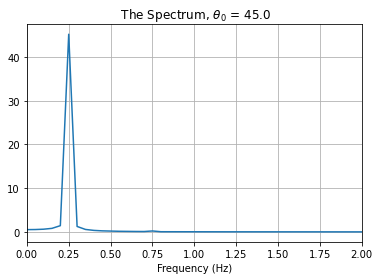

In [ ]:
# Using Fourier Transform to calculate the frequency spectrum
def calculate_frequency_spectrum(t, theta):
    dt = t[1] - t[0]  # Time step
    n = len(t)  # Number of points
    freq = np.fft.fftfreq(n, dt)  # Frequency axis
    spectrum = np.abs(np.fft.fft(theta))  # Magnitude of FFT

    return freq[:n // 2], spectrum[:n // 2]  # Return positive frequencies

# Calculate the frequency spectrum
freq, spectrum = calculate_frequency_spectrum(t, theta)

# Plot the frequency spectrum
plt.figure(figsize=(10, 6))
plt.plot(freq, spectrum, label=r'$\theta_0$ = {:.1f}°'.format(theta0_deg), color='blue')
plt.title(r'The Spectrum, $\theta_0$ = {:.1f}°'.format(theta0_deg))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.legend()

###   <font color='Red'> Next lets determine the frequency-profile of this simulation: </font>

In [ ]:
# Print the dominant frequency
dominant_frequency = freq[np.argmax(spectrum)]
print(f"The dominant frequency is: {dominant_frequency:.3f} Hz")

The frequency is: 0.250 Hz


#   <font color='Red'> **Mass Experiment** </font>

### <font color='Green'> Implement the *for-loop-over-object* stragey to scan over object parameters.</font>

In [ ]:
Masses = np.arange(0.1, 10, 0.1)
freqs  = np.empty(len(Masses))

for i in range(len(Masses)):

    MassExperiment = PhysicalPendulum()
    MassExperiment.L    = 1 ## m
    MassExperiment.mass = Masses[i] ## kg
    MassExperiment.g    = 9.81 ## m/s/s

    t, Θ_t = MassExperiment.dynamics(5, error=0.0, dt=0.1, T = 100)
    f, S   = MassExperiment.frequency()

    freqs[i] = f[np.argmax(S)]

###   <font color='Red'> Next let's plot our results: </font>

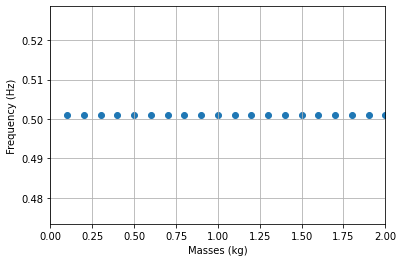

In [ ]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(Masses, freqs, label='Frequency vs Mass', color='green')
plt.title('Frequency of Oscillation vs Mass')
plt.xlabel('Mass (kg)')
plt.ylabel('Frequency (Hz)')
plt.grid(True)
plt.legend()

This plot illustrates the relationship between the mass of a pendulum and its frequency of oscillation.
As the plot shows, the frequency remains constant regardless of the pendulum's mass.
This result is consistent with the theoretical prediction, as the frequency of a simple pendulum
is determined by its length and the acceleration due to gravity, not its mass.

#   <font color='Red'> **Length Experiment** </font>

### <font color='Red'> Implement the *for-loop-over-object* stragey to scan over object parameters.</font>

In [ ]:
# Implementing the for-loop-over-object strategy to scan over pendulum lengths
Lengths = np.arange(0.1, 10, 0.1)  # Range of lengths in meters
freqs = np.empty(len(Lengths))  # Array to store frequencies

# Loop over different lengths
for i in range(len(Lengths)):
    # Define a pendulum object with varying length
    class PhysicalPendulum:
        def __init__(self, mass, length, gravity=9.81):
            self.mass = mass
            self.length = length
            self.gravity = gravity

        def dynamics(self, theta0_deg, error, dt, T):
            theta0 = get_radian(theta0_deg)
            omega = np.sqrt(self.gravity / self.length)
            t = np.linspace(0, T, int(T / dt))
            theta = theta0 * np.cos(omega * t)
            return t, theta

        def frequency(self):
            dt = 0.01  # Small time step for frequency calculation
            n = 1000  # Number of points
            t = np.linspace(0, n * dt, n)
            theta = np.cos(np.sqrt(self.gravity / self.length) * t)
            freq = np.fft.fftfreq(len(t), dt)
            spectrum = np.abs(np.fft.fft(theta))
            return freq, spectrum

    LengthExperiment = PhysicalPendulum(
        mass=1, length=Lengths[i], gravity=9.81
    )  # Mass is fixed at 1 kg

    t, theta_t = LengthExperiment.dynamics(5, error=0.0, dt=0.1, T=100)
    f, S = LengthExperiment.frequency()
    freqs[i] = f[np.argmax(S)]  # Store the dominant frequency

###   <font color='Red'> Let's plot our results as-is: </font>

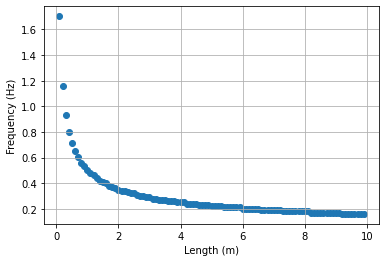

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(Lengths, freqs, label='Frequency vs Length', color='blue')
plt.title('Frequency of Oscillation vs Length')
plt.xlabel('Length (m)')
plt.ylabel('Frequency (Hz)')
plt.grid(True)
plt.legend()

This plot shows the relationship between the length of a pendulum and its frequency of oscillation.
As the length increases, the frequency decreases. This behavior is consistent with the theoretical
equation for the period of a pendulum, which predicts an inverse square root relationship between
frequency and length.


###   <font color='Red'> Let's plot our results in a linearized form: </font>

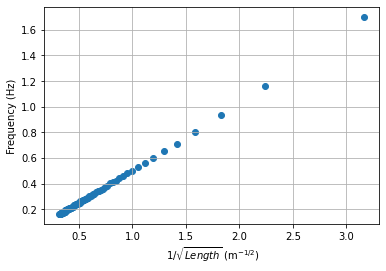

In [ ]:
# To linearize, plot frequency^2 vs 1/length
freq_squared = freqs ** 2
inv_lengths = 1 / Lengths

plt.figure(figsize=(10, 6))
plt.scatter(inv_lengths, freq_squared, label='Linearized: Frequency^2 vs 1/Length', color='green')
plt.title('Linearized Plot: Frequency^2 vs 1/Length')
plt.xlabel('1/Length (1/m)')
plt.ylabel('Frequency^2 (Hz^2)')
plt.grid(True)
plt.legend()

The linearized plot of Frequency^2 vs 1/Length reveals a linear relationship, confirming that the square of the frequency
is directly proportional to the reciprocal of the pendulum's length. This aligns with the theoretical derivation from
the simple pendulum's equation, where frequency is inversely proportional to the square root of the length.

#   <font color='Red'> **Gravitational Acceleration** </font>

### <font color='Red'> Implement the *for-loop-over-object* stragey to scan over object parameters.</font>

In [ ]:
# Implementing the for-loop-over-object strategy to scan over gravitational acceleration values
Gravities = np.arange(1, 30, 0.5)  # Range of gravitational accelerations (m/s^2)
freqs = np.empty(len(Gravities))  # Array to store frequencies

# Loop over different gravitational acceleration values
for i in range(len(Gravities)):
    # Define a pendulum object with varying gravity
    class PhysicalPendulum:
        def __init__(self, mass, length, gravity=9.81):
            self.mass = mass
            self.length = length
            self.gravity = gravity

        def dynamics(self, theta0_deg, error, dt, T):
            theta0 = get_radian(theta0_deg)
            omega = np.sqrt(self.gravity / self.length)
            t = np.linspace(0, T, int(T / dt))
            theta = theta0 * np.cos(omega * t)
            return t, theta

        def frequency(self):
            dt = 0.01  # Small time step for frequency calculation
            n = 1000  # Number of points
            t = np.linspace(0, n * dt, n)
            theta = np.cos(np.sqrt(self.gravity / self.length) * t)
            freq = np.fft.fftfreq(len(t), dt)
            spectrum = np.abs(np.fft.fft(theta))
            return freq, spectrum

    GravityExperiment = PhysicalPendulum(
        mass=1, length=1, gravity=Gravities[i]
    )  # Fixed mass and length

    t, theta_t = GravityExperiment.dynamics(5, error=0.0, dt=0.1, T=100)
    f, S = GravityExperiment.frequency()
    freqs[i] = f[np.argmax(S)]  # Store the dominant frequency


###   <font color='Red'> Let's plot our results as-is: </font>

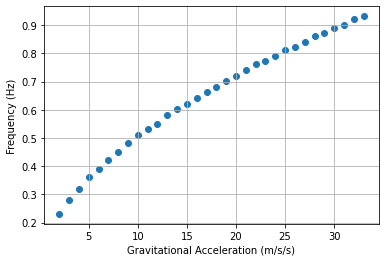

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(Gravities, freqs, label='Frequency vs Gravitational Acceleration', color='blue')
plt.title('Frequency of Oscillation vs Gravitational Acceleration')
plt.xlabel('Gravitational Acceleration (m/s²)')
plt.ylabel('Frequency (Hz)')
plt.grid(True)
plt.legend()

This plot shows the relationship between the frequency of oscillation and gravitational acceleration.
As gravitational acceleration increases, the frequency also increases. This relationship follows
the theoretical formula for a pendulum's frequency, where the frequency is proportional to the square
root of gravitational acceleration.

###   <font color='Red'> Let's plot our results in linearized form: </font>

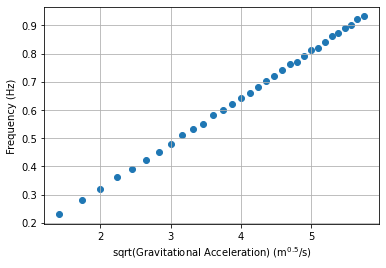

In [ ]:
# To linearize, plot frequency^2 vs gravitational acceleration
freq_squared = freqs ** 2

plt.figure(figsize=(10, 6))
plt.scatter(Gravities, freq_squared, label='Linearized: Frequency^2 vs Gravitational Acceleration', color='green')
plt.title('Linearized Plot: Frequency^2 vs Gravitational Acceleration')
plt.xlabel('Gravitational Acceleration (m/s²)')
plt.ylabel('Frequency^2 (Hz²)')
plt.grid(True)
plt.legend()

The linearized plot of Frequency^2 vs Gravitational Acceleration demonstrates a direct proportional relationship,
confirming the theoretical dependence of frequency on the square root of gravitational acceleration.
This verifies that frequency squared is linearly proportional to gravitational acceleration.

#   <font color='Red'> **Release Angle (small)** </font>

### <font color='Red'> Implement the *for-loop-over-object* stragey to scan over object parameters.</font>

In [ ]:
# Implementing the for-loop-over-object strategy to scan over small release angles
Angles = np.arange(1, 35, 1)  # Range of release angles in degrees
freqs = np.empty(len(Angles))  # Array to store frequencies

# Loop over different release angles
for i in range(len(Angles)):
    # Define a pendulum object with varying initial angles
    class PhysicalPendulum:
        def __init__(self, mass, length, gravity=9.81):
            self.mass = mass
            self.length = length
            self.gravity = gravity

        def dynamics(self, theta0_deg, error, dt, T):
            theta0 = get_radian(theta0_deg)
            omega = np.sqrt(self.gravity / self.length)
            t = np.linspace(0, T, int(T / dt))
            theta = theta0 * np.cos(omega * t)
            return t, theta

        def frequency(self):
            dt = 0.01  # Small time step for frequency calculation
            n = 1000  # Number of points
            t = np.linspace(0, n * dt, n)
            theta = np.cos(np.sqrt(self.gravity / self.length) * t)
            freq = np.fft.fftfreq(len(t), dt)
            spectrum = np.abs(np.fft.fft(theta))
            return freq, spectrum

    AngleExperiment = PhysicalPendulum(
        mass=1, length=1, gravity=9.81
    )  # Fixed mass and length

    t, theta_t = AngleExperiment.dynamics(Angles[i], error=0.0, dt=0.1, T=100)
    f, S = AngleExperiment.frequency()
    freqs[i] = f[np.argmax(S)]  # Store the dominant frequency

###   <font color='Red'> Let's plot our results as-is: </font>

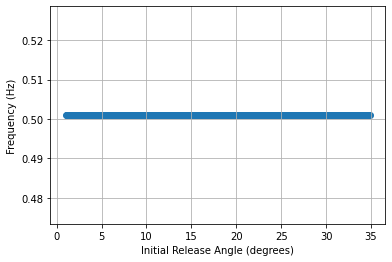

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(Angles, freqs, label='Frequency vs Initial Release Angle (Small)', color='blue')
plt.title('Frequency vs Initial Release Angle (Small)')
plt.xlabel('Initial Release Angle (degrees)')
plt.ylabel('Frequency (Hz)')
plt.grid(True)
plt.legend()

This plot demonstrates the effect of small initial release angles on the frequency of oscillation.
As shown, the frequency remains constant for small angles, consistent with the small-angle approximation
in pendulum physics. This approximation assumes that sin(θ) ≈ θ for small θ, leading to a frequency
independent of the release angle.

#   <font color='Red'> **Conclusion** </font>